In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
!pip install torch_geometric imblearn

import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score

In [3]:
data = pd.read_pickle("../data/transactions.pkl")

X = data.drop(['fraud', 'step'],axis=1)
y = data['fraud']

X.head()

,customer,age,gender,merchant,category,amount
0,210,4,2,30,12,-0.299276
1,2753,2,2,30,12,0.016067
2,2285,4,1,18,12,-0.098742
3,1650,3,2,30,12,-0.185275
4,3585,5,2,30,12,-0.019480


In [4]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

sm = SMOTE(random_state=26614)
X_res, y_res = sm.fit_resample(X_train, y_train)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Resampled set size: {X_res.shape[0]} samples")
print(f"Validation set size: {X_valid.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 356785 samples
Resampled set size: 704790 samples
Validation set size: 118929 samples
Testing set size: 118929 samples


In [5]:
import torch
from torch_geometric.data import Data, HeteroData

def create_gnn_data(df_X, df_y):
    # Create a mapping for categorical features
    age_map = {age: idx for idx, age in enumerate(df_X['age'].unique())}
    gender_map = {gender: idx for idx, gender in enumerate(df_X['gender'].unique())}
    category_map = {cat: idx for idx, cat in enumerate(df_X['category'].unique())}

    # Create a mapping for customer and merchant IDs
    customer_map = {customer: idx for idx, customer in enumerate(df_X['customer'].unique())}
    merchant_map = {merchant: idx for idx, merchant in enumerate(df_X['merchant'].unique())}
    transaction_map = {transaction: idx for idx, transaction in enumerate(df_X.index.unique())}

    # Create HeteroData object
    data = HeteroData()

    # Add customer nodes
    # data['customer'].num_nodes = len(df_X['customer'].unique())
    # data['customer'].x = torch.tensor([[age_map[age], gender_map[gender]] for age, gender in zip(df_X['age'], df_X['gender'])], dtype=torch.long)
    data['customer'].num_nodes = len(df_X['customer'].unique())
    #data['customer'].x = torch.tensor([[age_map[age], gender_map[gender]] for age, gender in zip(df_X['age'], df_X['gender'])], dtype=torch.float)
    #data['customer'].x = torch.tensor([[age_map[age], gender_map[gender]] for age, gender in zip(df_X['age'], df_X['gender'])], dtype=torch.float)
    data['customer'].x = torch.tensor(df_X['age'].values.reshape(-1, 1), dtype=torch.float)
    
    # Add merchant nodes
    data['merchant'].num_nodes = len(df_X['merchant'].unique())
    data['merchant'].x = torch.ones((data['merchant'].num_nodes, 1), dtype=torch.float)

    # # Add category nodes
    data['category'].num_nodes = len(df_X['category'].unique())
    data['category'].x = torch.ones((data['category'].num_nodes, 1), dtype=torch.float)

    # # Add gender nodes
    data['gender'].num_nodes = len(df_X['gender'].unique())
    data['gender'].x = torch.ones((data['gender'].num_nodes, 1), dtype=torch.float)

    # Add transaction nodes
    data['transaction'].num_nodes = len(df_X.index.unique())
    data['transaction'].x = torch.tensor(df_X['amount'].values.reshape(-1, 1), dtype=torch.float)
    data['transaction'].y = torch.tensor(df_y.values, dtype=torch.long)

    # Add customer-transaction edges
    customer_transaction_edge_index = torch.tensor([df_X['customer'].map(customer_map).values, df_X.index.map(transaction_map).values], dtype=torch.long)
    data['customer', 'to', 'transaction'].edge_index = customer_transaction_edge_index
    data['transaction', 'to', 'customer'].edge_index = customer_transaction_edge_index[[1, 0]]

    # Add merchant-transaction edges
    merchant_transaction_edge_index = torch.tensor([df_X['merchant'].map(merchant_map).values, df_X.index.map(transaction_map).values], dtype=torch.long)
    data['merchant', 'to', 'transaction'].edge_index = merchant_transaction_edge_index
    data['transaction', 'to', 'merchant'].edge_index = merchant_transaction_edge_index[[1, 0]]

    # # Add category-transaction edges
    category_transaction_edge_index = torch.tensor([df_X['category'].map(category_map).values, df_X.index.map(transaction_map).values], dtype=torch.long)
    data['category', 'to', 'transaction'].edge_index = category_transaction_edge_index
    data['transaction', 'to', 'category'].edge_index = category_transaction_edge_index[[1, 0]]
    
    
    # # Add category-transaction edges
    gender_customer_edge_index = torch.tensor([df_X['gender'].map(gender_map).values, df_X['customer'].map(customer_map).values], dtype=torch.long)
    data['gender', 'to', 'customer'].edge_index = gender_customer_edge_index
    data['customer', 'to', 'gender'].edge_index = gender_customer_edge_index[[1, 0]]
    
    return data

# Create PyTorch Geometric data
train_data = create_gnn_data(X_res, y_res)
valid_data = create_gnn_data(X_valid, y_valid)
test_data = create_gnn_data(X_test, y_test)

# Move data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data = train_data.to(device)
valid_data = valid_data.to(device)
test_data = test_data.to(device)

train_data.validate()

/tmp/ipykernel_582/1067660312.py:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  customer_transaction_edge_index = torch.tensor([df_X['customer'].map(customer_map).values, df_X.index.map(transaction_map).values], dtype=torch.long)


True

In [6]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import SAGEConv, to_hetero, GCNConv, GATConv

class SimpleGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), 64)
        self.conv2 = SAGEConv((-1, -1), 64)
        self.conv3 = SAGEConv((-1, -1), out_channels)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.dropout1(x)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.dropout2(x)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return x

# Create the model
in_channels = train_data.num_features
hidden_channels = 64
out_channels = 2
model = SimpleGNN(hidden_channels, out_channels).to(device)
model = to_hetero(model, train_data.metadata())

# Training loop
# num_epochs = 500
# for epoch in range(num_epochs):
#     model.train()
#     out = model(train_data.x_dict, train_data.edge_index_dict)
    
#     loss = criterion(out['transaction'], train_data['transaction'].y)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if (epoch + 1) % 10 == 0:
#         # Evaluate on validation set
#         model.eval()
#         with torch.no_grad():
#             out = model(valid_data.x_dict, valid_data.edge_index_dict)
#             predicted = out['transaction'].argmax(dim=1)
#             accuracy = accuracy_score(valid_data['transaction'].y.cpu(), predicted.cpu())
#             precision = precision_score(valid_data['transaction'].y.cpu(), predicted.cpu())
#             recall = recall_score(valid_data['transaction'].y.cpu(), predicted.cpu())
#             f1 = f1_score(valid_data['transaction'].y.cpu(), predicted.cpu())

#         print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# # Evaluate on test set
# model.eval()
# with torch.no_grad():
#     out = model(test_data.x_dict, test_data.edge_index_dict)
#     predicted = out['transaction'].argmax(dim=1)
#     accuracy = accuracy_score(test_data['transaction'].y.cpu(), predicted.cpu())
#     precision = precision_score(test_data['transaction'].y.cpu(), predicted.cpu())
#     recall = recall_score(test_data['transaction'].y.cpu(), predicted.cpu())
#     f1 = f1_score(test_data['transaction'].y.cpu(), predicted.cpu())

# print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

In [7]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.00001)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    out = model(train_data.x_dict, train_data.edge_index_dict)
    
    loss = criterion(out['transaction'], train_data['transaction'].y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        # Evaluate on validation set
        model.eval()
        with torch.no_grad():
            out = model(valid_data.x_dict, valid_data.edge_index_dict)
            predicted = out['transaction'].argmax(dim=1)
            accuracy = accuracy_score(valid_data['transaction'].y.cpu(), predicted.cpu())
            precision = precision_score(valid_data['transaction'].y.cpu(), predicted.cpu())
            recall = recall_score(valid_data['transaction'].y.cpu(), predicted.cpu())
            f1 = f1_score(valid_data['transaction'].y.cpu(), predicted.cpu())

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Evaluate on test set
model.eval()
with torch.no_grad():
    out = model(test_data.x_dict, test_data.edge_index_dict)
    predicted = out['transaction'].argmax(dim=1)
    accuracy = accuracy_score(test_data['transaction'].y.cpu(), predicted.cpu())
    precision = precision_score(test_data['transaction'].y.cpu(), predicted.cpu())
    recall = recall_score(test_data['transaction'].y.cpu(), predicted.cpu())
    f1 = f1_score(test_data['transaction'].y.cpu(), predicted.cpu())

print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Epoch [10/500], Loss: 0.3292, Accuracy: 0.9925, Precision: 0.6579, Recall: 0.7523, F1-score: 0.7019
Epoch [20/500], Loss: 0.2971, Accuracy: 0.9944, Precision: 0.8088, Recall: 0.6834, F1-score: 0.7409
Epoch [30/500], Loss: 0.1493, Accuracy: 0.9937, Precision: 0.7239, Recall: 0.7416, F1-score: 0.7326
Epoch [40/500], Loss: 0.1220, Accuracy: 0.9928, Precision: 0.6590, Recall: 0.8062, F1-score: 0.7252
Epoch [50/500], Loss: 0.1017, Accuracy: 0.9922, Precision: 0.6335, Recall: 0.8004, F1-score: 0.7073
Epoch [60/500], Loss: 0.0956, Accuracy: 0.9895, Precision: 0.5340, Recall: 0.8126, F1-score: 0.6445
Epoch [70/500], Loss: 0.0920, Accuracy: 0.9921, Precision: 0.6270, Recall: 0.7940, F1-score: 0.7007
Epoch [80/500], Loss: 0.0896, Accuracy: 0.9928, Precision: 0.6638, Recall: 0.7839, F1-score: 0.7189
Epoch [90/500], Loss: 0.0916, Accuracy: 0.9916, Precision: 0.6068, Recall: 0.8076, F1-score: 0.6929
Epoch [100/500], Loss: 0.0773, Accuracy: 0.9929, Precision: 0.6665, Recall: 0.7947, F1-score: 0.7250

In [17]:
# Evaluate on test set
model.eval()
with torch.no_grad():
    out = model(test_data.x_dict, test_data.edge_index_dict)
    y_prob = F.softmax(out['transaction'], dim=1)[:, 1].cpu().numpy()
    y_pred = (y_prob > 0.165).astype(int)

cr = classification_report(test_data['transaction'].y.cpu().numpy(), y_pred)
cm = confusion_matrix(test_data['transaction'].y.cpu().numpy(), y_pred)

print("Classification Report for GNN: \n", cr)
print("Confusion Matrix of GNN: \n", cm)

Classification Report for GNN: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    117512
           1       0.66      0.87      0.75      1417

    accuracy                           0.99    118929
   macro avg       0.83      0.93      0.87    118929
weighted avg       0.99      0.99      0.99    118929

Confusion Matrix of GNN: 
 [[116884    628]
 [   184   1233]]


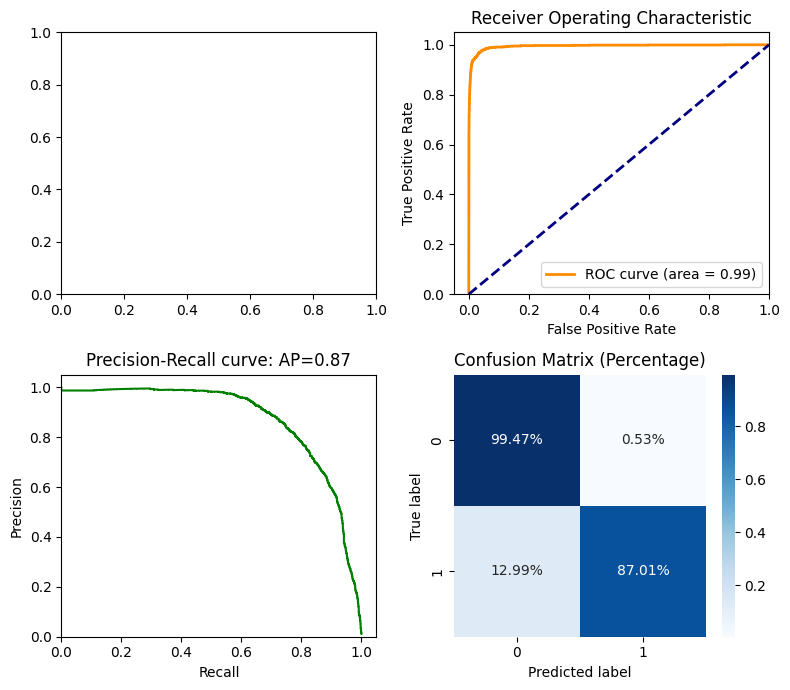

In [18]:
# ROC Curve calculation
fpr, tpr, thresholds = roc_curve(test_data['transaction'].y.cpu().numpy(), y_prob)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve calculation
precision, recall, _ = precision_recall_curve(test_data['transaction'].y.cpu().numpy(), y_prob)
average_precision = average_precision_score(test_data['transaction'].y.cpu().numpy(), y_prob)

# Confusion Matrix calculation
cm = confusion_matrix(test_data['transaction'].y.cpu().numpy(), y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))

# Plot ROC Curve
axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 1].set_xlim([-0.05, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('Receiver Operating Characteristic')
axes[0, 1].legend(loc="lower right")

# Plot Precision-Recall Curve
axes[1, 0].step(recall, precision, where='post', color='green')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlim([0.0, 1.05])
axes[1, 0].set_title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# Plot Confusion Matrix
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix (Percentage)')
axes[1, 1].set_xlabel('Predicted label')
axes[1, 1].set_ylabel('True label')

# Adjust layout
plt.tight_layout()
plt.show()